# Sample Notebook - NER with frozen/partly frozen encoder

As the pre-trained model shall already provide meaningful representations, a common choice in the literature is to fine-tune:
- only the last classification head 
- the last encoding layers + classification head!

This helps providing:
- Faster training (much less trainable parameters!)
- Less chances to "overfit" with too many parameters!

## Let's see how to do it!
### Notice: most of the code is the same as before, and will not be commented!

In [1]:
import pandas as pd
INPUT_PATH = "CyNER_dataset"
train_df = pd.read_parquet(f"{INPUT_PATH}/train.parquet")
test_df = pd.read_parquet(f"{INPUT_PATH}/test.parquet")

In [2]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [3]:
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)), 
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)), 
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)), 
    }
)

In [4]:
def convert_labels_to_ids(sample):
    sample['tags_id'] = [label2id[el] for el in sample["tags"]]
    return sample
unique_labels = list(train_df.tags.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
encoded_dataset = full_ds.map(convert_labels_to_ids)

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

In [5]:
from transformers import AutoTokenizer
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)

In [6]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text.

    This function maps word-level labels to their corresponding tokens after tokenization.
    It handles special tokens (with None word_ids) and subword tokens (multiple tokens for one word).
    Args:
       labels (list): Original word-level labels.
       word_ids (list): List of word indices that each token corresponds to.
                        None values represent special tokens.
    Returns:
       list: New token-aligned labels where:
            - Special tokens (None word_ids) are assigned -100
            - First token of each word gets the word's label
            - Continuation tokens of the same word also get the word's label
    Example:
       labels = [0, 1, 2]  # Labels for 3 words
       word_ids = [None, 0, 0, 1, 2, 2, None]  # Tokenized into 7 tokens
       result = [-100, 0, 0, 1, 2, 2, -100]  # Aligned labels
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

In [7]:
def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens.
    This function processes a batch of examples by:
    1. Tokenizing the text in 'sentences' field
    2. Converting word-level labels to token-level labels for each example
    3. Adding the aligned labels back to the tokenized inputs
    Args:
       examples (dict): Dictionary containing:
           - 'sentences': List of text sentences
           - 'tags_id': List of lists containing word-level tags for each command
    Returns:
       dict: Tokenized inputs with aligned labels:
           - Standard tokenizer outputs (input_ids, attention_mask, etc.)
           - 'labels': Token-level labels aligned with the tokenized inputs
    Notes:
       - Uses a pre-defined tokenizer (must be available in scope)
       - Sets is_split_into_words=True because input is already word-tokenized
       - Uses align_labels_with_tokens helper function to handle subword tokenization
    """
    # Remember: we need to split the sentences 
    split_sentences = [sentence.split() for sentence in samples["sentences"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences, 
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["tags_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [8]:
original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

In [9]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

## We load the model again:

In [11]:
pretrained_model = "google-bert/bert-base-uncased"

In [12]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at

### Now, let's say that we want to fine-tune only the last 2 encoding layers + classification head. 

In [13]:
# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

#### Sanity check: which layers are we actually training?

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

bert.encoder.layer.10.attention.self.query.weight
bert.encoder.layer.10.attention.self.query.bias
bert.encoder.layer.10.attention.self.key.weight
bert.encoder.layer.10.attention.self.key.bias
bert.encoder.layer.10.attention.self.value.weight
bert.encoder.layer.10.attention.self.value.bias
bert.encoder.layer.10.attention.output.dense.weight
bert.encoder.layer.10.attention.output.dense.bias
bert.encoder.layer.10.attention.output.LayerNorm.weight
bert.encoder.layer.10.attention.output.LayerNorm.bias
bert.encoder.layer.10.intermediate.dense.weight
bert.encoder.layer.10.intermediate.dense.bias
bert.encoder.layer.10.output.dense.weight
bert.encoder.layer.10.output.dense.bias
bert.encoder.layer.10.output.LayerNorm.weight
bert.encoder.layer.10.output.LayerNorm.bias
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.val

#### We can also know how many parameters we are training!

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

Full model has 108,900,107 parameters


In [16]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")

However, we will only train: 14,184,203


### Again, from now on we have the same training pipeline!

#### Define training parameters

In [17]:
from torch.optim import AdamW
LR = 5e-5
N_TRAIN_EPOCHS = 30
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

In [18]:
from transformers import get_scheduler
num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

##### Remember: the model is going to classify all tokens > we need a function to post-process and gather the predictions!

In [19]:
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]: 
            A tuple containing two lists:
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
            - `true_labels`: The list of true label sequences with special tokens removed.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

##### Define metrics and a function named `compute_metrics` 

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np 

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels  
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    } 
    return metrics

##### Initialize some variable to keep track of the best model during training

In [21]:
from copy import deepcopy 
# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

##### Optionally, move everything to GPU if it's defined

In [22]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
model.device

device(type='cuda', index=0)

##### Eventually, run the training loop!

In [23]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], 
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        ) 
        # Notice: the model already comes with a CrossEntropy loss 
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)   
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/5550 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


epoch 0: {'token_accuracy': 0.9206027353689568, 'token_f1': 0.3514716795034035}
epoch 1: {'token_accuracy': 0.9378180661577609, 'token_f1': 0.5241829415271304}
epoch 2: {'token_accuracy': 0.9438613231552163, 'token_f1': 0.5971277127891047}
epoch 3: {'token_accuracy': 0.9551924300254453, 'token_f1': 0.661189477883689}
epoch 4: {'token_accuracy': 0.9560671119592875, 'token_f1': 0.686216618263676}
epoch 5: {'token_accuracy': 0.9580947837150128, 'token_f1': 0.7141494954016132}
epoch 6: {'token_accuracy': 0.9609971374045801, 'token_f1': 0.728475302777633}
epoch 7: {'token_accuracy': 0.9604007633587787, 'token_f1': 0.7327429126218246}
epoch 8: {'token_accuracy': 0.9587706743002544, 'token_f1': 0.7428180980701881}
epoch 9: {'token_accuracy': 0.9637802162849872, 'token_f1': 0.8092251177538275}
epoch 10: {'token_accuracy': 0.9637006997455471, 'token_f1': 0.7628129399861643}
epoch 11: {'token_accuracy': 0.9639392493638677, 'token_f1': 0.7859570880010037}
epoch 12: {'token_accuracy': 0.9642573155

#### Plot losses after the training loop

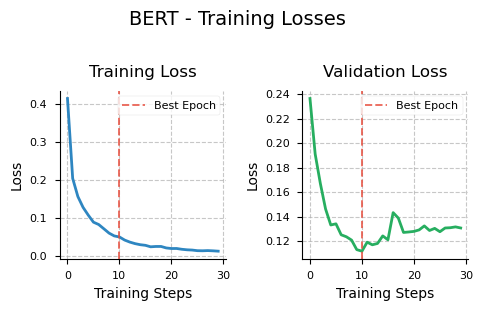

In [24]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)
    
    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses, 
           validation_losses=val_losses, best_epoch=best_epoch)

### After training, move to the test phase!

In [25]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)   

In [26]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  95.99%
token_f1            :  75.87%
token_precision     :  87.06%
token_recall        :  72.27%


#### Also plot the confusion matrix

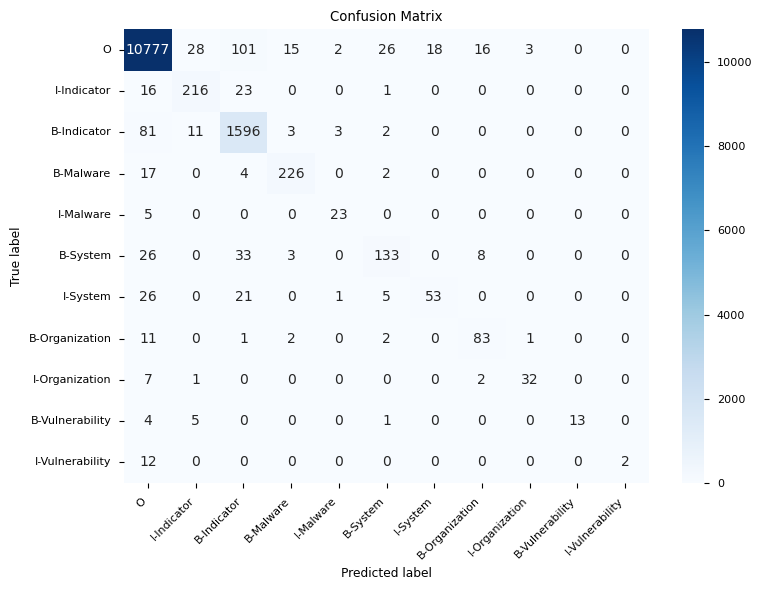

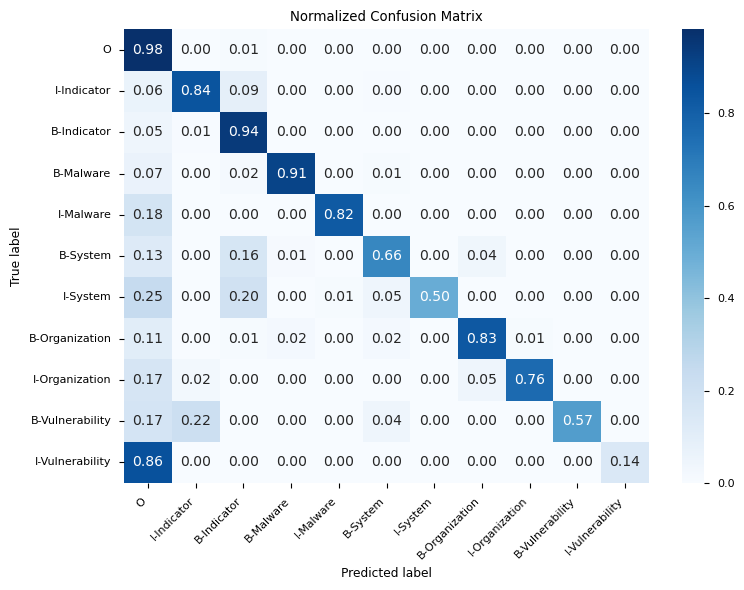

array([[9.80975787e-01, 2.54869834e-03, 9.19351902e-03, 1.36537411e-03,
        1.82049882e-04, 2.36664846e-03, 1.63844894e-03, 1.45639905e-03,
        2.73074823e-04, 0.00000000e+00, 0.00000000e+00],
       [6.25000000e-02, 8.43750000e-01, 8.98437500e-02, 0.00000000e+00,
        0.00000000e+00, 3.90625000e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.77594340e-02, 6.48584906e-03, 9.41037736e-01, 1.76886792e-03,
        1.76886792e-03, 1.17924528e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.82730924e-02, 0.00000000e+00, 1.60642570e-02, 9.07630522e-01,
        0.00000000e+00, 8.03212851e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.78571429e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.21428571e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)